# This is a notebook about predicting aurora

# 0. Data Downloading

In [1]:
import os
import joblib

# General packages
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Visualization packages
import matplotlib.pyplot as plt
import plotly.express as px
from plotting import *

# Matplotlib settings
plt.style.use("ggplot")
plt.rcParams.update({
    "font.size": 14, 
    "axes.labelweight": "bold", 
    "figure.figsize": (7, 5), 
    "lines.linewidth": 2
})

# Statsmodels and forecasting tools
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ETSModel

# Evaluation metrics
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error

# Sktime forecasting and model selection
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.model_selection import SlidingWindowSplitter, ForecastingRandomizedSearchCV
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.compose import EnsembleForecaster
from sktime.regression.distance_based import KNeighborsTimeSeriesRegressor
from sktime.regression.deep_learning.mlp import MLPRegressor
from sktime.regression.deep_learning import (
    CNNRegressor, SimpleRNNRegressor, InceptionTimeRegressor, ResNetRegressor, LSTMFCNRegressor
)

# Machine learning models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import uniform, randint

# Pipeline Steps

In [3]:
# 1. Data Loading and Cleaning
from load_and_clean_kpindex import load_and_clean_kpindex
daily_max_df = load_and_clean_kpindex()

,Datetime,Kp_Index
0,1932-01-01,3.333
1,1932-01-02,5.000
2,1932-01-03,3.333
3,1932-01-04,2.000
4,1932-01-05,2.000


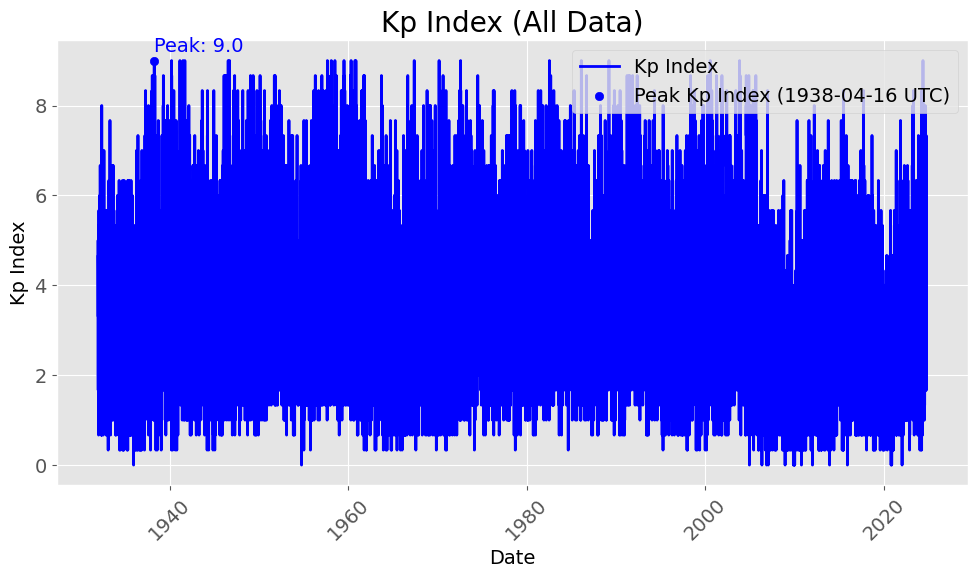

In [14]:
# 2 Optional: Exploratory Data Analysis
from plot_kp_index_and_annual_stats import plot_kp_index_and_annual_stats
plot_kp_index_and_annual_stats(daily_max_df)

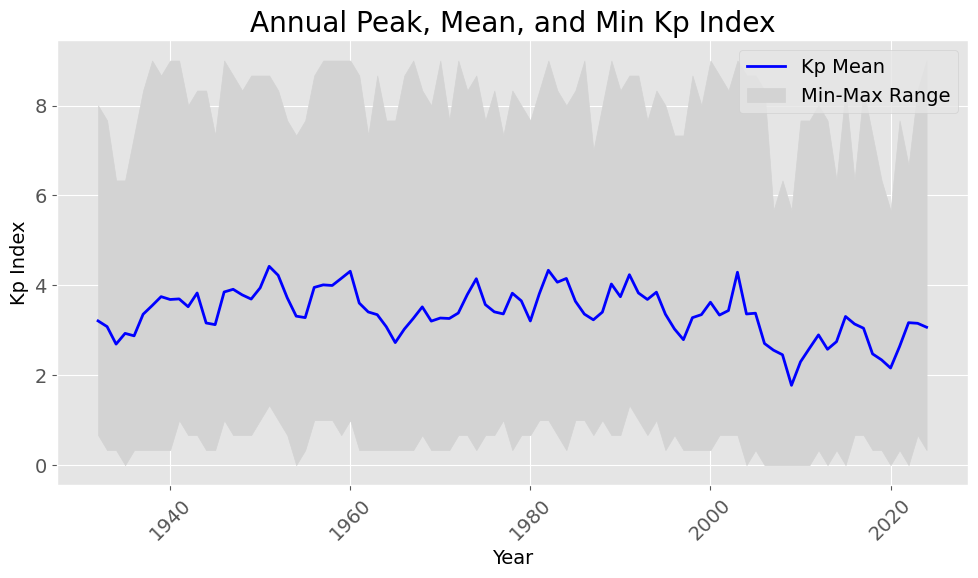

In [5]:
plot_kp_index_and_annual_stats(daily_max_df, annual_min_max=True)

In [6]:
# Define a list of date ranges for each month in 2024
date_ranges = [
    ('2024-01-01', '2024-02-01'),
    ('2024-02-01', '2024-03-01'),
    ('2024-03-01', '2024-04-01'),
    ('2024-04-01', '2024-05-01'),
    ('2024-05-01', '2024-06-01'),
    ('2024-06-01', '2024-07-01'),
    ('2024-07-01', '2024-08-01'),
    ('2024-08-01', '2024-09-01'),
    ('2024-09-01', '2024-10-01'),
    ('2024-10-01', '2024-11-01'),
]

# Loop through each date range and corresponding axis
for i, (start_date, end_date) in enumerate(date_ranges):
    plot_kp_index_and_annual_stats(daily_max_df, start_date, end_date, y_lim=(0,9))


In [11]:
# 2. Trend and Seasonal Decomposition
from trend_seasonal_decomposition import trend_seasonal_decomposition, plot_decomposition

daily_max_df_2000 = trend_seasonal_decomposition(daily_max_df)

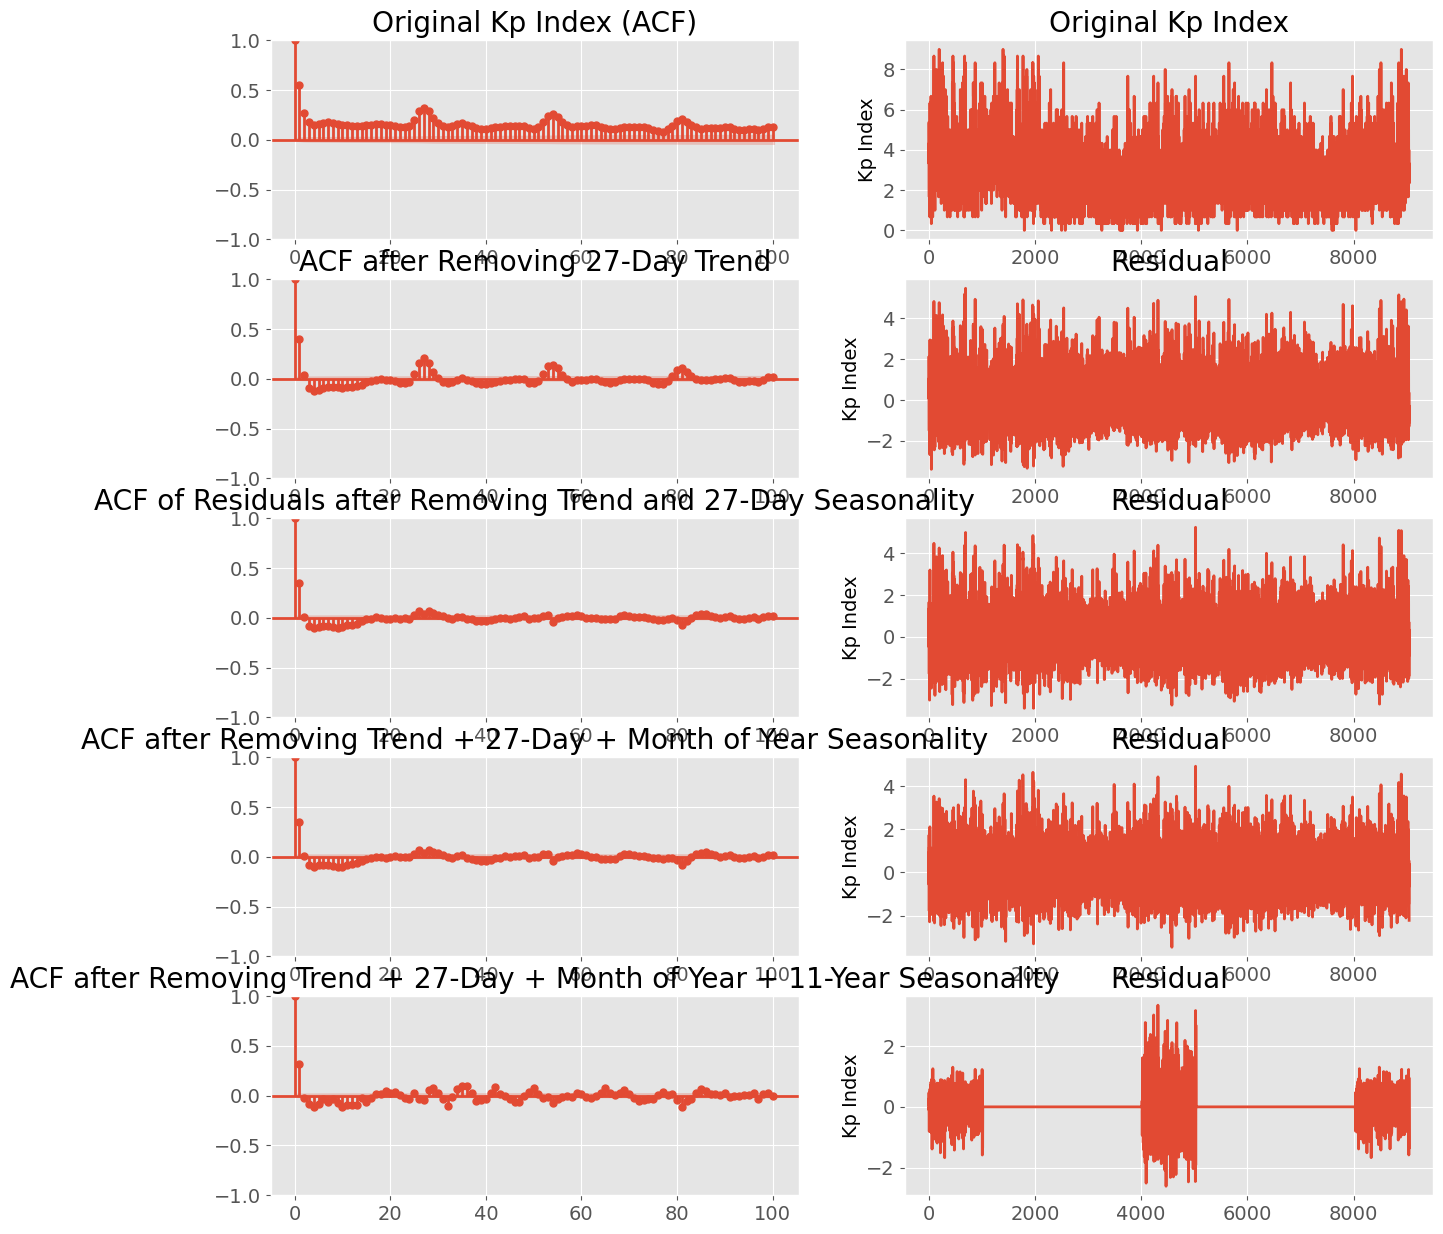

In [15]:
# 2.1 Optional Plotting Decomposition Steps
plot_decomposition(daily_max_df_2000)

In [16]:
# 2.2 Check stationarity
from stationarity import plot_stationarity, check_stationarity
check_stationarity(daily_max_df_2000, 'Kp_Index', 'Residual_detrended_27_MoY')

,Test,ADF Statistic,p-value
0,Original,-7.34e+00,1.04e-10
1,Residual Detrended,-2.77e+01,0.00e+00


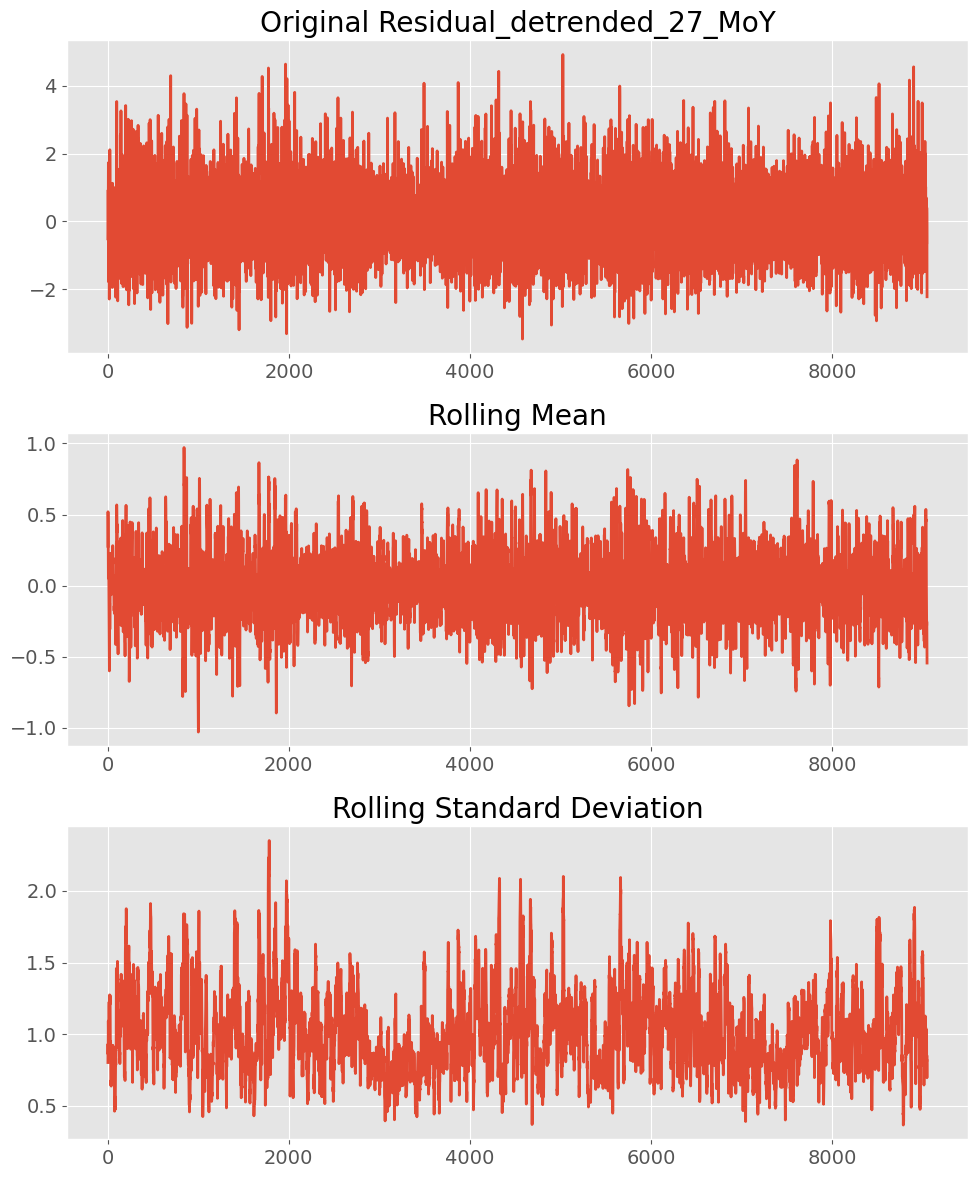

In [17]:
plot_stationarity(daily_max_df_2000, 'Residual_detrended_27_MoY')

In [35]:
daily_max_df_2000.columns

Index(['11_Year_Group', 'Day_Sun_rotation', 'Datetime', 'Kp_Index',
       'Poly. fit (order 0)', 'Poly. fit (order 1)', 'Poly. fit (order 2)',
       'detrended', 'Day_of_Month', 'Mean_dayofmonth_peak_Kp',
       'Min_dayofmonth_peak_Kp', 'Max_dayofmonth_peak_Kp', 'Month',
       'Mean_monthly_peak_Kp', 'Min_monthly_peak_Kp', 'Max_monthly_peak_Kp',
       'remainder', 'Day_Sun_rotation_x', 'Year', '11_Year_Group_x',
       'Day_Sun_rotation_y', 'Mean_sunrotation_peak_Kp',
       'Min_sunrotation_peak_Kp', 'Max_sunrotation_peak_Kp', '11_Year_Group_y',
       'Mean_solarcycle_peak_Kp', 'Min_solarcycle_peak_Kp',
       'Max_solarcycle_peak_Kp', 'Residual_27', 'Residual_detrended_27',
       'Trend_27', 'Seasonal_27', 'Residual_detrended_27_MoY',
       'Seasonal_MonthofYear', 'Detrended_Deseasonalized_Kp_Index',
       'Seasonal_SolarCycle'],
      dtype='object')

In [36]:
daily_max_df_2000_cleaned = daily_max_df_2000.drop(
    columns=[
        "Poly. fit (order 0)",
        "Poly. fit (order 1)",
        "Poly. fit (order 2)",
        "detrended",
        "Min_dayofmonth_peak_Kp",
        "Max_dayofmonth_peak_Kp",
        "Min_monthly_peak_Kp",
        "Max_monthly_peak_Kp",
        "remainder",
        "11_Year_Group_x",
        "Day_Sun_rotation_x",
        "Day_Sun_rotation_y",
        "Min_sunrotation_peak_Kp",
        "Max_sunrotation_peak_Kp",
        "11_Year_Group_y",
        "Min_solarcycle_peak_Kp",
        "Max_solarcycle_peak_Kp",
        "Detrended_Deseasonalized_Kp_Index",
    ]
)

daily_max_df_2000_cleaned.head()

,11_Year_Group,Day_Sun_rotation,Datetime,Kp_Index,Day_of_Month,Mean_dayofmonth_peak_Kp,Month,Mean_monthly_peak_Kp,Year,Mean_sunrotation_peak_Kp,Mean_solarcycle_peak_Kp,Residual_27,Residual_detrended_27,Trend_27,Seasonal_27,Residual_detrended_27_MoY,Seasonal_MonthofYear,Seasonal_SolarCycle
0,4,1,2000-01-01,5.333,1,3.067124,1,2.788832,2000,2.983078,3.130476,2.078821,1.278933,3.254179,0.799889,0.891177,0.387756,0.961341
1,4,2,2000-01-02,3.333,2,2.898215,1,2.788832,2000,3.012973,3.130476,0.076035,-0.475998,3.256965,0.552033,-0.025552,-0.450446,0.073669
2,4,3,2000-01-03,3.333,3,2.780758,1,2.788832,2000,2.968164,3.130476,0.072958,-0.467127,3.260042,0.540084,-0.550815,0.083688,-0.748865
3,4,4,2000-01-04,3.667,4,2.919199,1,2.788832,2000,2.950257,3.130476,0.403579,0.113897,3.263421,0.289682,-0.267979,0.381876,-0.500528
4,4,5,2000-01-05,4.000,5,2.927017,1,2.788832,2000,2.884567,3.130476,0.732885,1.116557,3.267115,-0.383672,1.334950,-0.218393,0.867505


# 2. Modeling

In [37]:
# Define our df to contain the observed data.
daily_max_df_2000to2023 = daily_max_df_2000_cleaned[daily_max_df_2000_cleaned['Datetime'] < '2024-01-01'].set_index("Datetime")

df_observed = daily_max_df_2000to2023[['Kp_Index']]
df_observed['Label'] = 'Observed'
df_observed.tail()

,Kp_Index,Label
Datetime,,
2023-12-27,2.000,Observed
2023-12-28,1.667,Observed
2023-12-29,2.333,Observed
2023-12-30,2.333,Observed
2023-12-31,1.333,Observed


In [38]:
# Creating the forecasting index
def create_forecast_index(start, horizon, freq="D"):
    return pd.date_range(start + pd.tseries.frequencies.to_offset(freq), periods=horizon, freq=freq, name="Datetime")

forecast_index = create_forecast_index(daily_max_df_2000to2023.index[-1], 365)

forecast_index[:5]

DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05'],
              dtype='datetime64[ns]', name='Datetime', freq='D')

## 2.1 Seasonal naive model (average of Sun Rotation and Month of Year seasonalities)

Work completed up to here.
---

My typical approach is as follows

- Naive (seasonally-adjusted if necessary) / Seasonal naive
- ETS (for SES, or Holt, seasonally-adjust if necessary)
- ARIMA
- ML (next lecture)
- Combinations of the above

In [39]:
# Define the length of sun rotation, which is every 27 days.
days_sun_rotation = 27

# Step 1: Seasonal Naive Model of the 27-days seasonality. We use the last 27-days cycle in 2023 to make prediction for 2024.
seasonal_naive_27 = daily_max_df_2000to2023['Kp_Index'][-days_sun_rotation:].reset_index(drop=True)

# Step 2: Seasonal Naive Model for month of the year seasonality. We use the average monthly value from 2023 to make prediction for 2024.
seasonal_naive_month = daily_max_df_2000to2023[daily_max_df_2000to2023['Year'] == 2023].groupby('Month')['Kp_Index'].mean()

# Step 3: Combine the two models to make prediction for 2024.
combined_seasonal_naive = np.zeros(365)

for i in range(len(combined_seasonal_naive)):
    # Identify the day in sun rotation and the month
    current_day_sun_rotation = i % 27
    current_month = (pd.Timestamp('2024-01-01') + pd.Timedelta(days=i)).month
    # Location the contribution from the two models
    kp_27_contribution = seasonal_naive_27.iloc[current_day_sun_rotation]
    kp_month_contribution = seasonal_naive_month.loc[current_month]
    # Average of the two models
    combined_seasonal_naive[i] = (kp_27_contribution + kp_month_contribution) / 2

# Step 4: Create a DataFrame for the predictions
naive_preds_df = pd.DataFrame(
    {"Label": "Seasonal naive forecast", "Kp_Index": combined_seasonal_naive},
    index=forecast_index,
)

px.line(pd.concat((df_observed, naive_preds_df)), y="Kp_Index", color="Label", width=1600)

## 2.2 Mixed Seasonal average model (sun rotation average, month of year average, and 11 year rotation average since 2000)

In [40]:
daily_max_df_2000to2023.tail(1)

,11_Year_Group,Day_Sun_rotation,Kp_Index,Day_of_Month,Mean_dayofmonth_peak_Kp,Month,Mean_monthly_peak_Kp,Year,Mean_sunrotation_peak_Kp,Mean_solarcycle_peak_Kp,Residual_27,Residual_detrended_27,Trend_27,Seasonal_27,Residual_detrended_27_MoY,Seasonal_MonthofYear,Seasonal_SolarCycle
Datetime,,,,,,,,,,,,,,,,,
2023-12-31,5,18,1.333,31,3.009642,12,2.594091,2023,2.715427,3.128945,-0.993397,-0.995092,2.326397,0.001696,-0.755633,-0.239459,-0.525784


In [41]:
# Step 1: Calculating the three grouped averages.
sun_rotation = daily_max_df_2000to2023.groupby(daily_max_df_2000to2023['Day_Sun_rotation']).agg(Mean_sunrotation_peak_Kp=('Kp_Index', 'mean'))
month_of_year = daily_max_df_2000to2023.groupby(daily_max_df_2000to2023.index.month).agg(Mean_monthly_peak_Kp=('Kp_Index', 'mean'))
solar_cycle = daily_max_df_2000to2023.groupby(daily_max_df_2000to2023['11_Year_Group']).agg(Mean_solarcycle_peak_Kp=('Kp_Index', 'mean'))

# Step 2: Combine the three averages to make prediction for 2024.
combined_seasonal_average = np.zeros(365)

for i in range(len(combined_seasonal_average)):
    # 2024-01-01 is the 14th day in sun rotation, 1st month in the year, and 7th year in the 11-year group.
    current_day_sun_rotation = (i + 13) % 27 + 1
    current_month = (pd.Timestamp('2024-01-01') + pd.Timedelta(days=i)).month
    current_11_yeargroup = 7
    # Locate the contribution from the three averages
    day_of_sun_contribution = sun_rotation.loc[current_day_sun_rotation]['Mean_sunrotation_peak_Kp']
    month_of_year_contribution = month_of_year.loc[current_month]['Mean_monthly_peak_Kp']
    solar_cycle_contribution = solar_cycle.loc[current_11_yeargroup]['Mean_solarcycle_peak_Kp']
    # Average of the three contributions
    combined_seasonal_average[i] = (day_of_sun_contribution + month_of_year_contribution + solar_cycle_contribution) / 3

# Step 3: Create a DataFrame for the predictions
combined_seasonal_average_preds_df = pd.DataFrame(
    {"Label": "Combined seasonal averages", "Kp_Index": combined_seasonal_average},
    index=forecast_index,
)

px.line(pd.concat((df_observed, naive_preds_df, combined_seasonal_average_preds_df)), y="Kp_Index", color="Label", width=1600)

## 2.3 ETS (Error, Trend, Seasonal) Model

In [42]:
aan_model = ETSModel(daily_max_df_2000to2023["Kp_Index"], error="add", trend="add", freq="D").fit()
ets_aan = pd.DataFrame({"Kp_Index": aan_model.forecast(len(forecast_index)),
                        "Label": "ETS (AAN)"},
                       index=forecast_index)

aaa_model = ETSModel(daily_max_df_2000to2023["Kp_Index"], error="add", trend="add", seasonal="add", seasonal_periods=27, freq="D").fit()
ets_aaa = pd.DataFrame({"Kp_Index": aaa_model.forecast(len(forecast_index)),
                        "Label": "ETS (AAA)"},
                       index=forecast_index)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72614D+00    |proj g|=  9.99000D-02

At iterate    1    f=  1.69176D+00    |proj g|=  1.39709D-01

At iterate    2    f=  1.68859D+00    |proj g|=  1.49482D-01

At iterate    3    f=  1.68013D+00    |proj g|=  7.97365D-02

At iterate    4    f=  1.67748D+00    |proj g|=  7.33400D-02

At iterate    5    f=  1.66879D+00    |proj g|=  9.88229D-03

At iterate    6    f=  1.66860D+00    |proj g|=  1.08587D-02

At iterate    7    f=  1.66856D+00    |proj g|=  2.32210D-01

At iterate    8    f=  1.66855D+00    |proj g|=  1.25233D-02

At iterate    9    f=  1.66854D+00    |proj g|=  1.28419D-02

At iterate   10    f=  1.66853D+00    |proj g|=  2.75310D-02

At iterate   11    f=  1.66851D+00    |proj g|=  1.20827D-01

At iterate   12    f=  1.66847D+00    |proj g|=  2.70495D-01

At iterate   13    f=  1.6

In [43]:
autoets_model = AutoETS(auto=True, n_jobs=-1, sp=27, freq="D", random_state = 123)
autoets_model.fit(daily_max_df_2000to2023["Kp_Index"])
ets_auto = pd.DataFrame({"Kp_Index": autoets_model.predict(fh=forecast_index),
                        "Label": "ETS (Auto)"},
                       index=forecast_index)

/opt/miniconda3/envs/mds574/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/miniconda3/envs/mds574/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/miniconda3/envs/mds574/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/miniconda3/envs/mds574/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/miniconda3/envs/mds574/lib/python3.10/s

In [44]:
px.line(pd.concat((df_observed, naive_preds_df, combined_seasonal_average_preds_df, ets_aan, ets_aaa, ets_auto)), y="Kp_Index", color="Label", width=1600)

In [45]:
q = 0.975  # 95% prediction intervals
simulations = aaa_model.simulate(anchor="end", nsimulations=365, repetitions=100, random_errors="bootstrap")
simulations = pd.DataFrame({"median": simulations.median(axis=1),
                            "pi_lower": simulations.quantile((1 - q), axis=1),
                            "pi_upper": simulations.quantile(q, axis=1)},
                           index=forecast_index)

plot_prediction_intervals(df_observed['Kp_Index'], simulations, "median", xlabel="Datetime", ylabel="Kp Index", width=1600)

In [46]:
pd.DataFrame({"AIC": [aan_model.aic, aaa_model.aic],
              "BIC": [aan_model.bic, aaa_model.bic],
              "MSE": [aan_model.mse, aaa_model.mse]},
             index=["(AAN)", "(AAA)"]).round(2)

,AIC,BIC,MSE
(AAN),29237.06,29272.45,1.64
(AAA),29250.77,29484.36,1.63


## 2.4 TBATS (Trigonometric, Box-Cox, ARMA Errors, Trend, and Seasonal Components):

TBATS can handle multiple seasonalities. You can use the tbats package, which supports complex seasonality (e.g., daily and yearly patterns).

In [47]:
# The runtime for this model is around 8 minutes. I'm saving it to the models folder.
# # Create a TBATS model
# estimator = TBATS(sp=[27, 365.25])  # Weekly and sun rotation (27-day) seasonality
# tbats_model = estimator.fit(daily_max_df_2000to2023["Kp_Index"])
# tbats_model.save(path="./models/tbats_model")

# Loading a saved TBATS model
estimator = TBATS()
tbats_model = estimator.load_from_path("./models/tbats_model.zip")

In [48]:
tbats_forecast = pd.DataFrame({"Kp_Index": tbats_model.predict(fh=forecast_index),
                        "Label": "TBATS"},
                       index=forecast_index)

px.line(pd.concat((df_observed, naive_preds_df, combined_seasonal_average_preds_df, ets_aaa, tbats_forecast)), y="Kp_Index", color="Label", width=1600)

## 2.5 ARIMA

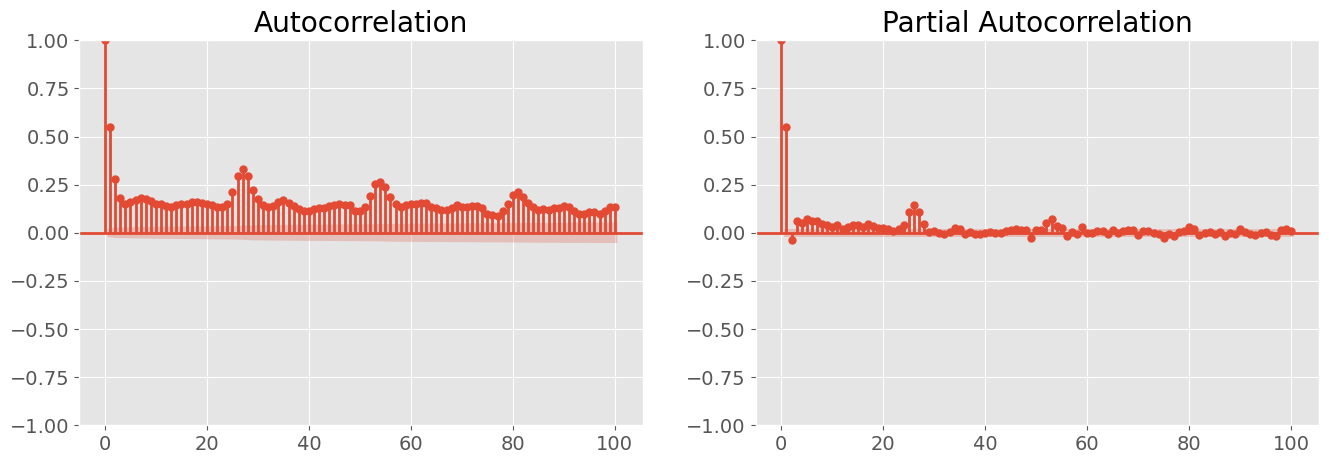

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
plot_acf(daily_max_df_2000to2023["Kp_Index"], lags=100, ax=axes[0])
plot_pacf(daily_max_df_2000to2023["Kp_Index"], lags=100, ax=axes[1]);

From the ACF plot, we can see that the MA(q) value is 1 or 2. From the PACF plot, we can see that the AR(p) value is 1. 

Of course, we can use `AutoARIMA` to help me find the model with the smallest AIC. 

In [50]:
sarimax = pm.auto_arima(daily_max_df_2000to2023["Kp_Index"], n_jobs = -1, start_q=0,start_d=1,start_p=0,
                            max_q=5, max_d=5, max_p=5, random_state=123)

print(sarimax.summary())

The `AutoARIMA` determines the model with AR(2), d=1, and MA(1) has the smallest AIC. Let's use this to train a seasonal ARIMA model.

In [51]:
# model_sarima = ARIMA(daily_max_df_2000to2023["Kp_Index"], order=(2, 1, 1), seasonal_order=(1, 1, 1, 27)).fit()

In [52]:
# print(model_sarima.summary())

```
SARIMAX Results                                     
========================================================================================
Dep. Variable:                         Kp_Index   No. Observations:                 8766
Model:             ARIMA(2, 1, 1)x(1, 1, 1, 27)   Log Likelihood              -13643.071
Date:                          Sun, 22 Sep 2024   AIC                          27298.143
Time:                                  04:02:26   BIC                          27340.595
Sample:                              01-01-2000   HQIC                         27312.610
                                   - 12-31-2023                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4835      0.010     50.345      0.000       0.465       0.502
ar.L2         -0.0878      0.010     -8.531      0.000      -0.108      -0.068
ma.L1         -0.9860      0.002   -510.783      0.000      -0.990      -0.982
ar.S.L27       0.1117      0.010     11.117      0.000       0.092       0.131
ma.S.L27      -0.9854      0.003   -384.796      0.000      -0.990      -0.980
sigma2         1.3152      0.016     84.226      0.000       1.285       1.346
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1365.89
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                             0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
```

In [68]:
# sarima_forecast = pd.DataFrame({"Kp_Index": model_sarima.forecast(len(forecast_index)),
#                         "Label": "SARIMA"},
#                        index=forecast_index)

# px.line(pd.concat((df_observed, naive_preds_df, combined_seasonal_average_preds_df, ets_aaa, tbats_forecast, sarima_forecast)), y="Kp_Index", color="Label", width=1600)

In [69]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
# plot_acf(model_sarima.resid, lags=100, ax=axes[0])
# plot_pacf(model_sarima.resid, lags=100, ax=axes[1]);

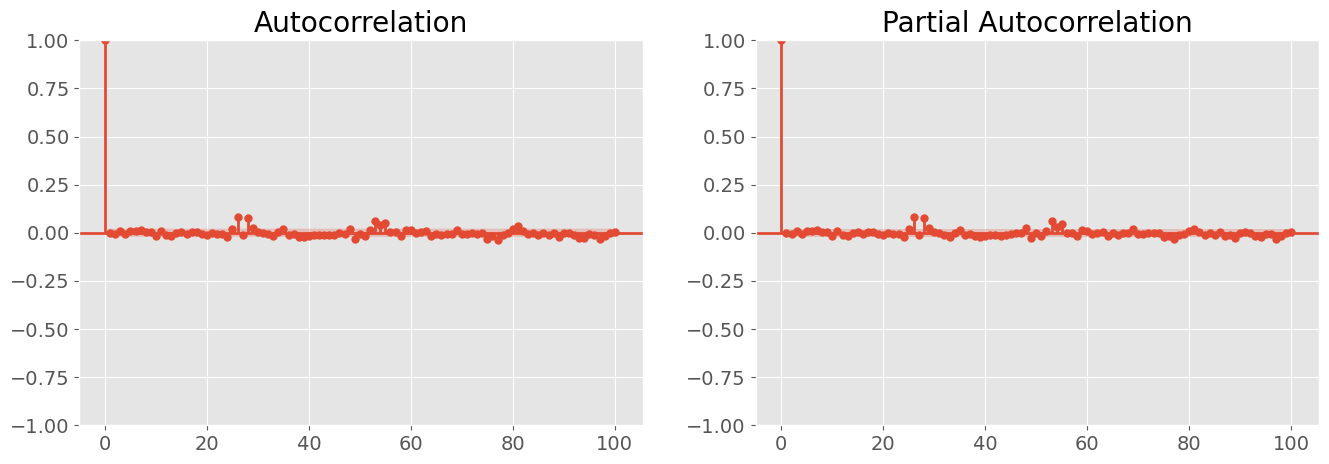

We can see that this model was doing pretty well in capturing the autocorrelation and seasonality of the data. 

# 3. Machine-Learning Modelling

## 3.1 Train-Valid-Test Split

Before building our model, we need to split the data into a training set (for model training) and a test set (to evaluate model performance). As for time-series, this has special consideration as 1) we do not shuffle the data to preserve the temporal component and 2) we use a sliding window approach for cross-validation. 

Training data length: 8311
One-fold validation data length: 365
Test data length: 365


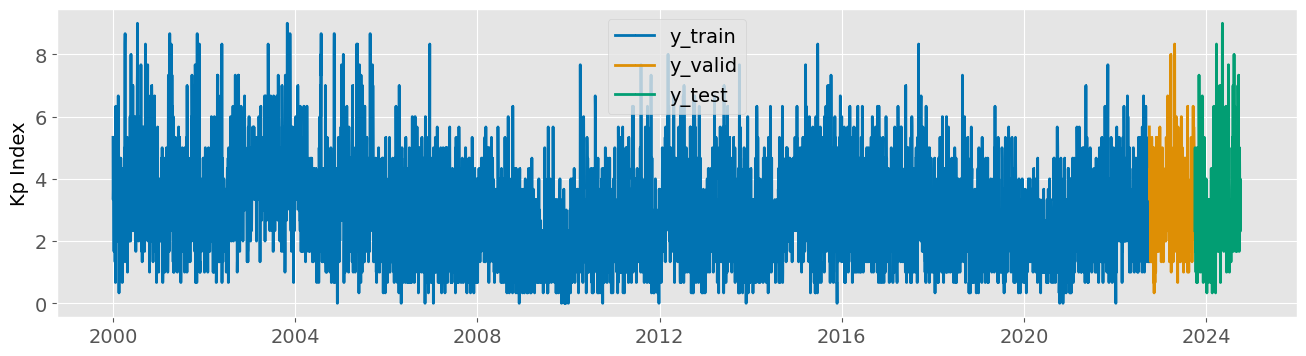

In [70]:
today = datetime.today()

# Calculate the start date of the test set (365 days ago from today)
test_start_date = today - timedelta(days=365)
valid_start_date = test_start_date - timedelta(days=365)

df = daily_max_df_2000_cleaned.set_index("Datetime")

train_set, valid_set, test_set = df[(df.index < valid_start_date)], df[(df.index >= valid_start_date) & (df.index < test_start_date)], df[df.index >= test_start_date]
X_train, y_train = train_set.drop(columns=['Kp_Index']), train_set['Kp_Index']
X_valid, y_valid = valid_set.drop(columns=['Kp_Index']), valid_set['Kp_Index']
X_test, y_test = test_set.drop(columns=['Kp_Index']), test_set['Kp_Index']

fig, ax = plot_series(y_train, y_valid, y_test, labels=["y_train", "y_valid", "y_test"], y_label="Kp Index", markers=[',',',', ','])

# Verify the split
print(f"Training data length: {len(y_train)}")
print(f"One-fold validation data length: {len(y_valid)}")
print(f"Test data length: {len(y_test)}")

So in this split, we are assigning the data from 2024 as unseen test data. This will not be used in model training at all. At the final stage after I have fine-tuned our model, I will then use the test data to evaludate the model's performance. Remember, the golden rule of machine learning is that the algorithm/model should not see the test set until the very last step to report score. 

For the sake of saving training time during coding phase, I will perform one-fold validation on all data from 2023 and the use data before 2023 as the training set. 

In [71]:
# Specify forecast horizon. This has the same length minus one as the test set.
fh = ForecastingHorizon(np.arange(1,len(y_valid)+1))
len(fh)

365

In [72]:
# For each of the validation fold, we set the training set to 11 years (4015 days) and the validation set to 1 year (365 days).
cv = SlidingWindowSplitter(window_length=len(y_valid), step_length=int(len(y_valid)/2), fh=fh)

n_splits = cv.get_n_splits(y_train)
print(f"Number of Folds = {n_splits}")

Number of Folds = 42


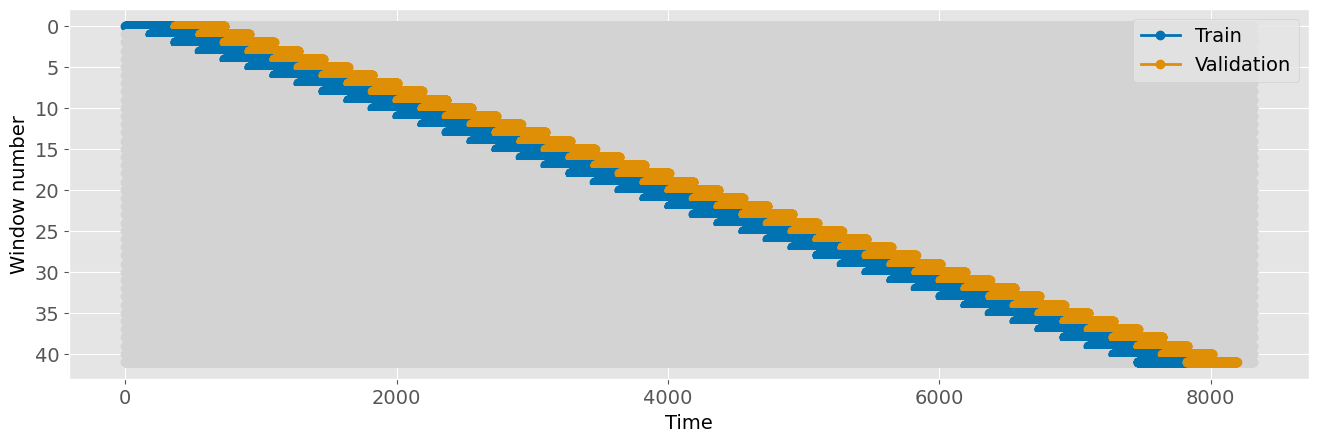

In [73]:
train_windows, test_windows = get_windows(y_train, cv)

plot_windows(y_train, train_windows, test_windows)

## 3.2 Feature Engineering/Transformation

These transformations will have minimal effects on tree-based models but will help tremendously on linear models. 

In [74]:
# X_train.columns

In [75]:
# # Continuous features to scale
# continuous_features = [
#     "Mean_dayofmonth_peak_Kp",
#     "Mean_monthly_peak_Kp",
#     "Mean_sunrotation_peak_Kp",
#     "Mean_solarcycle_peak_Kp",
#     "Residual_27",
#     "Residual_detrended_27",
#     "Trend_27",
#     "Seasonal_27",
#     "Residual_detrended_27_MoY",
#     "Seasonal_MonthofYear",
#     "Seasonal_SolarCycle",
# ]

# # Ordinal features
# ordinal_features = ["11_Year_Group", "Year"]

In [76]:
# # Cyclical transformer class
# class CyclicalTransformer(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         X_copy = X.copy()  # Avoid modifying the original DataFrame
#         X_copy['Day_of_Month_sin'] = np.sin(2 * np.pi * X_copy['Day_of_Month'] / 31)
#         X_copy['Day_of_Month_cos'] = np.cos(2 * np.pi * X_copy['Day_of_Month'] / 31)
#         X_copy['Month_sin'] = np.sin(2 * np.pi * X_copy['Month'] / 12)
#         X_copy['Month_cos'] = np.cos(2 * np.pi * X_copy['Month'] / 12)
#         X_copy['Day_Sun_rotation_sin'] = np.sin(2 * np.pi * X_copy['Day_Sun_rotation'] / 27)
#         X_copy['Day_Sun_rotation_cos'] = np.cos(2 * np.pi * X_copy['Day_Sun_rotation'] / 27)
#         return X_copy[['Day_of_Month_sin', 'Day_of_Month_cos', 'Month_sin', 'Month_cos', 'Day_Sun_rotation_sin', 'Day_Sun_rotation_cos']]

#     def get_feature_names_out(self, input_features=None):
#         return np.array(['Day_of_Month_sin', 'Day_of_Month_cos', 'Month_sin', 'Month_cos', 'Day_Sun_rotation_sin', 'Day_Sun_rotation_cos'])

# # Combine everything in a pipeline
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('numerical', StandardScaler(), continuous_features),
#         ('ordinal', OrdinalEncoder(), ordinal_features),
#         ('cyclical', CyclicalTransformer(), ['Day_of_Month', 'Month', 'Day_Sun_rotation']),
#     ],
#     remainder='drop'  # Drop any features not specified in transformers
# )

# # Apply the transformation
# X_train_transformed = preprocessor.fit_transform(X_train)
# X_valid_transformed = preprocessor.transform(X_valid)

# # Convert to DataFrame and add Datetime index
# X_train_transformed = pd.DataFrame(X_train_transformed, columns=preprocessor.get_feature_names_out())
# X_train_transformed.index = X_train.index

# X_valid_transformed = pd.DataFrame(X_valid_transformed, columns=preprocessor.get_feature_names_out())
# X_valid_transformed.index = X_valid.index


## 3.3 First glance at model performances

In [77]:
# Define forecasters
forecasters = {
    "NaiveForecaster": NaiveForecaster(strategy="last"),
#     "LinearRegression": make_reduction(LinearRegression(), strategy="recursive", window_length=27),
    "KNN": make_reduction(KNeighborsTimeSeriesRegressor(n_neighbors=5), strategy="recursive", window_length=27),
    "RandomForest": make_reduction(RandomForestRegressor(n_estimators=100, random_state=123), strategy="recursive", window_length=27),
    "GradientBoosting": make_reduction(GradientBoostingRegressor(n_estimators=100, random_state=123), strategy="recursive", window_length=27),
    "XGBoost": make_reduction(XGBRegressor(n_estimators=100, random_state=123), strategy="recursive", window_length=27),
    "LightGBM": make_reduction(LGBMRegressor(n_estimators=100, random_state=123), strategy="recursive", window_length=27),
    "CatBoost": make_reduction(CatBoostRegressor(n_estimators=100, random_state=123, silent=True), strategy="recursive", window_length=27),
#     "SVR": make_reduction(SVR(), strategy="recursive", window_length=27),
#     "MLP": make_reduction(MLPRegressor(random_state=123), strategy="recursive", window_length=27),
#     "ElasticNet": make_reduction(ElasticNet(), strategy="recursive", window_length=27),
    "CNNRegressor": make_reduction(CNNRegressor(random_state=123, n_epochs=3000), strategy="recursive", window_length=27),
    "InceptionTimeRegressor": make_reduction(InceptionTimeRegressor(random_state=123, n_epochs=3000), strategy="recursive", window_length=27),
    "ResNetRegressor": make_reduction(ResNetRegressor(random_state=123, n_epochs=3000), strategy="recursive", window_length=27),
    "LSTMFCNRegressor": make_reduction(LSTMFCNRegressor(random_state=123, n_epochs=3000), strategy="recursive", window_length=27),
}

In [78]:
# # Store results
# forecasters_results = {}

# # Dictionary to store model parameters
# model_params = {}

# # Dictionary to store the results
# results = {
#     'Model': [],
#     'MAPE': [],
#     'RMSE': [], 
#     'R2': []
# }

# # Train and evaluate all forecasters
# for name, forecaster in forecasters.items():
#     print(f"Training {name}...")
#     forecaster.fit(y_train, X=X_train, fh=fh)
    
#     # Predict
#     prediction = forecaster.predict(X=X_valid, fh=fh)
#     forecasters_results[name]=prediction
    
#     # Append results to the dictionary
#     results['Model'].append(name)
#     results['MAPE'].append(mean_absolute_percentage_error(y_valid, prediction))
#     results['RMSE'].append(np.sqrt(mean_squared_error(y_valid, prediction)))
#     results['R2'].append(r2_score(y_valid, prediction))
    
#     # Save the fine-tuned model
#     joblib.dump(forecaster, save_dir + name + "_oneshot.pkl")
    
#     # Get parameters and store in dictionary
#     model_params[name] = forecaster.get_params()
    
#     print(f"Finished Training {name}.")

Let's take a look at how each model performs.

In [79]:
# pd.DataFrame(results).set_index("Model").sort_values(by="MAPE").style.background_gradient(cmap="Blues", axis=0)

In [80]:
# params_df = pd.DataFrame(model_params).T

# # Display DataFrame
# params_df

The ideal model would predict the Kp Index with the smallest MAPE and RMSE, and has an R2 score close to +1. So far, looks like LightGBM is winning. MLP and LinearRegression are not doing very well for this task.

In [81]:
# y_train_plot = pd.DataFrame(y_train)
# y_valid_plot = pd.DataFrame(y_valid)

# y_train_plot['Label'] = "Train"
# y_valid_plot['Label'] = "Valid"

# plotting_df = pd.concat((y_train_plot, y_valid_plot))

# for model, predictions in forecasters_results.items():
#     predictions_df = pd.DataFrame(predictions)
#     predictions_df['Label'] = model
#     plotting_df = pd.concat((plotting_df, predictions_df))

# px.line(plotting_df, color="Label")

The predictions made by the LinearRegression and MLP models are very off the scale. Looks like the decision tree-based models are doing pretty well on this task. 

Let's do more hyperparameter optimization to fine-tune these models (all under 50% MAPE):

- LightGBM
- XGBoost
- GradientBoosting
- SVR
- RandomForest
- CatBoost

As most of these models are decision tree-based, they don't really require feature transformation such as standscaling or ordinal encoding. We can skip step 3.2 in our fine-tuning step.

## 3.4 Fine-tuning model

Training data length: 8676
Test data length: 365


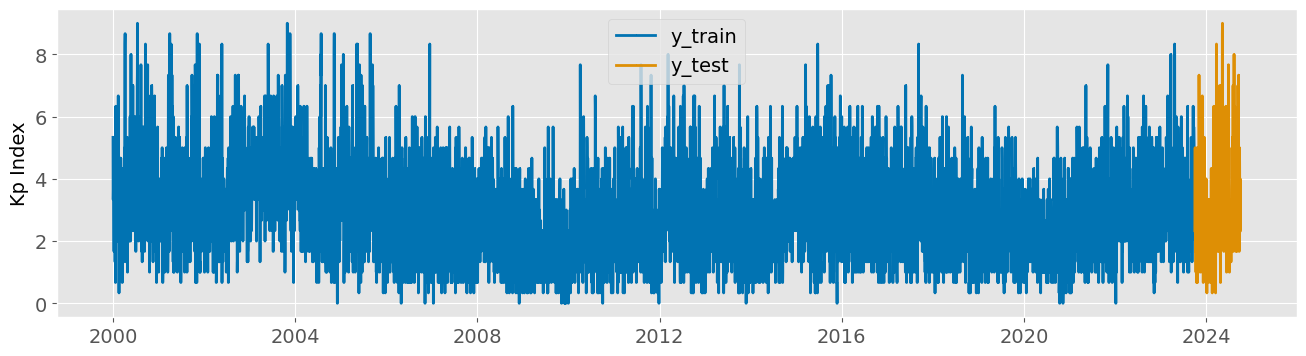

In [82]:
today = datetime.today()

# Calculate the start date of the test set (365 days ago from today)
test_start_date = today - timedelta(days=365)

df = daily_max_df_2000_cleaned.set_index("Datetime")

train_set, test_set = df[df.index < test_start_date], df[df.index >= test_start_date]

X_train, y_train = train_set.drop(columns=['Kp_Index']), train_set['Kp_Index']
X_test, y_test = test_set.drop(columns=['Kp_Index']), test_set['Kp_Index']
fig, ax = plot_series(y_train, y_test, labels=["y_train", "y_test"], y_label="Kp Index", markers=[',',','])

# Verify the split
print(f"Training data length: {len(y_train)}")
print(f"Test data length: {len(y_test)}")

In [83]:
# Specify forecast horizon. This has the same length minus one as the test set.
fh = ForecastingHorizon(np.arange(1,len(y_test)+1))
len(fh)
# For each of the validation fold, we set the training set to 11 years (4015 days) and the validation set to 1 year (365 days).
cv = SlidingWindowSplitter(window_length=len(y_test), step_length=int(len(y_test)/2), fh=fh)

n_splits = cv.get_n_splits(y_train)
print(f"Number of Folds = {n_splits}")

Number of Folds = 44


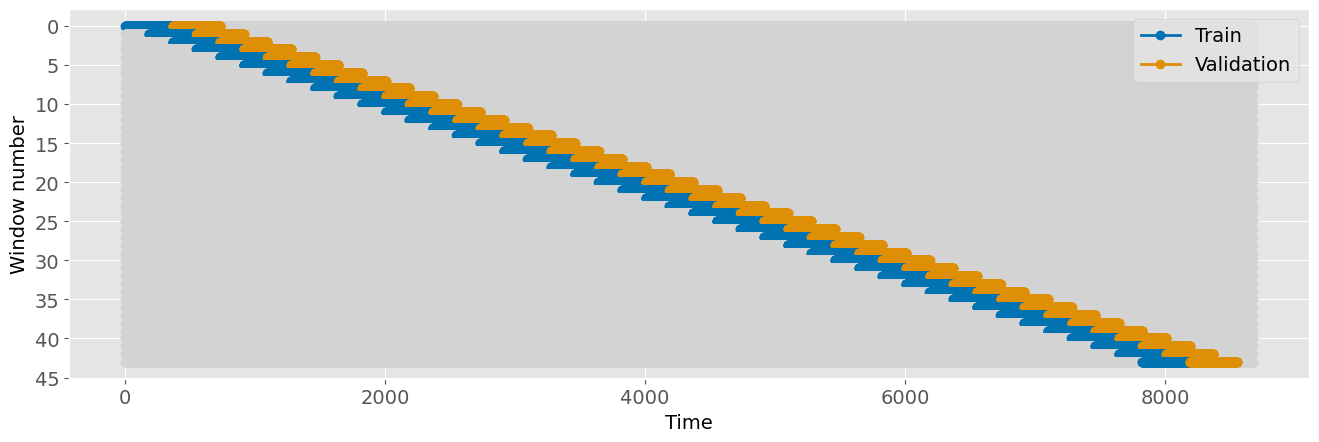

In [84]:
train_windows, test_windows = get_windows(y_train, cv)

plot_windows(y_train, train_windows, test_windows)

In [85]:
# Define forecasters with hyperparameter grids
forecasters = {
    # Basic/linear models
    "NaiveForecaster": NaiveForecaster(strategy="last"),
#     "LinearRegression": make_reduction(LinearRegression(), strategy="recursive", window_length=27),
#     "KNN": make_reduction(KNeighborsTimeSeriesRegressor(n_neighbors=5), strategy="recursive", window_length=27),
#     "SVR": make_reduction(SVR(), strategy="recursive", window_length=27),
#     "MLP": make_reduction(MLPRegressor(random_state=123), strategy="recursive", window_length=27),
#     "ElasticNet": make_reduction(ElasticNet(), strategy="recursive", window_length=27),
    
#     # Neural Network models
#     "CNNRegressor": make_reduction(CNNRegressor(random_state=123, n_epochs=3000), strategy="recursive", window_length=27),
#     "InceptionTimeRegressor": make_reduction(InceptionTimeRegressor(random_state=123, n_epochs=3000), strategy="recursive", window_length=27),
#     "ResNetRegressor": make_reduction(ResNetRegressor(random_state=123, n_epochs=3000), strategy="recursive", window_length=27),
#     "LSTMFCNRegressor": make_reduction(LSTMFCNRegressor(random_state=123, n_epochs=3000), strategy="recursive", window_length=27),
    
    # GBM/tree-based models
    "LightGBM": make_reduction(LGBMRegressor(random_state=123, verbose=-1), strategy="recursive", window_length=27),
    "XGBoost": make_reduction(XGBRegressor(random_state=123), strategy="recursive", window_length=27),
    "GradientBoosting": make_reduction(GradientBoostingRegressor(random_state=123), strategy="recursive", window_length=27),
    "RandomForest": make_reduction(RandomForestRegressor(random_state=123), strategy="recursive", window_length=27),
#     "CatBoost": make_reduction(CatBoostRegressor(random_state=123), strategy="recursive", window_length=27),
}

# Hyperparameter grids for RandomizedSearchCV
param_grids = {
    "LightGBM": {
        "num_leaves": randint(10, 100),
        "max_depth": randint(3, 8),
        "learning_rate": uniform(0.01, 0.30),
    },
    "XGBoost": {
        "max_depth": randint(3, 8),
        "learning_rate": uniform(0.01, 0.30),
    },
    "GradientBoosting": {
        "max_depth": randint(3, 8),
        "learning_rate": uniform(0.01, 0.30),
        "n_estimators": randint(10, 100),  # Adjusted range for n_estimators
    },
    "RandomForest": {
        "n_estimators": randint(10, 100),  # Adjusted range for n_estimators
        "max_depth": randint(5, 21),
        "min_samples_split": randint(2, 11),
    },
    "CatBoost": {
        "estimator__iterations": randint(10, 100),  # Adjusted range for iterations
        "estimator__learning_rate": uniform(0.01, 0.30),
        "estimator__depth": randint(3, 10),  # Adjusted range for depth
    },
}

In [87]:
# # Store results
# forecasters_results_ft = {}
# best_forecasters = {}

# # Train and evaluate all forecasters
# for name, forecaster in forecasters.items():
#     print(f"Training {name}...")
    
#     # Check if hyperparameter grid exists
#     if name in param_grids:
#         search = ForecastingRandomizedSearchCV(
#             forecaster= forecaster,
#             param_distributions=param_grids[name],
#             n_iter=20,
#             random_state=123,
#             strategy='refit',
#             cv=cv,
#             n_jobs=-1
#         )
#         search.fit(y_train, X=X_train)
#         best_forecaster = search.best_forecaster_
#         best_forecasters[name] = search.best_forecaster_
#         evaluation_results = evaluate(forecaster=best_forecaster, y=y_train, X=X_train, cv=cv, strategy="refit", return_data=True)
#         # Save the fine-tuned model
#         joblib.dump(best_forecaster, save_dir + name + "_cv_ft.pkl")
#     else:
#         print(f"Forecaster {name} does not have param_grid set up! Will train using default hyperparameters.")
#         evaluation_results = evaluate(forecaster=forecaster, y=y_train, X=X_train, cv=cv, strategy="refit", return_data=True)
#         # Save the fine-tuned model
#         joblib.dump(forecaster, save_dir + name + "_cv.pkl")
    
#     # Store results from evaluation
#     forecasters_results_ft[name] = evaluation_results
    
#     print(f"Finished Training {name}.")


In [ ]:
# # Create the ensemble forecaster with a median aggregation function
# print("Training EnsembleForecaster...")
# ensemble_forecaster = EnsembleForecaster(
#     forecasters=[(name, best_forecaster) for name, best_forecaster in best_forecasters.items()],
#     aggfunc="median"
# )

# # Fit and evaluate the ensemble model
# ensemble_forecaster.fit(y_train, X=X_train)
# ensemble_name = "EnsembleForecaster_median"

# # Save the ensemble model
# joblib.dump(ensemble_forecaster, save_dir + ensemble_name + ".pkl")

# # Evaluate and store the ensemble model results
# ensemble_results = evaluate(forecaster=ensemble_forecaster, y=y_train, X=X_train, cv=cv, strategy="refit", return_data=True)
# forecasters_results_ft[ensemble_name] = ensemble_results

# print("Finished Training EnsembleForecaster.")

In [ ]:
# # Dictionary to store aggregated results
# aggregated_results = {
#     'Model': [],
#     'Mean_MAPE': [],
#     'Std_MAPE': []
# }

# # Aggregate MAPE for each model
# for model_name, results in forecasters_results_ft.items():
#     mape_values = results['test_MeanAbsolutePercentageError']
    
#     # Calculate mean and standard deviation
#     mean_mape = np.mean(mape_values)
#     std_mape = np.std(mape_values)
    
#     # Append to aggregated results
#     aggregated_results['Model'].append(model_name)
#     aggregated_results['Mean_MAPE'].append(mean_mape)
#     aggregated_results['Std_MAPE'].append(std_mape)

# # Convert aggregated results to DataFrame for better visualization
# aggregated_results_df = pd.DataFrame(aggregated_results)

# # Display the aggregated results
# aggregated_results_df.set_index("Model").sort_values(by="Mean_MAPE").style.background_gradient(cmap="Blues", axis=0)


In [ ]:
# # Looking at the forecasting for one of the validation set. 
# index = -2

# plotting_df = pd.DataFrame(forecasters_results_ft['LightGBM'].iloc[index,]['y_test'])
# plotting_df['Label'] = 'y_valid'

# for name in forecasters_results_ft.keys():
#     predictions_df = pd.DataFrame(forecasters_results_ft[name].iloc[index,]['y_pred'])
#     predictions_df['Label'] = name
#     plotting_df = pd.concat((plotting_df, predictions_df))
    
# px.line(plotting_df, color="Label", width=1600)

In [ ]:
# for name in best_forecasters.keys():
#     print(best_forecasters[name].estimator)

Note that in the plot, May 12 has the highest peak in Kp Index. It is indeed that aurora was observed on that day in many places across the globe.

From the plot, we can conclude:
1. NaiveForecaster, serving as the baseline, does not make predictions for our task. 
2. CatBoost	although having a low average MAPE at 0.472414, does not make good predictions.
3. LightGBM	although having a low average MAPE at 0.478600, does not make good predictions.
4. RandomForest having a MAPE of 0.488835, does not make good predictions.
5. XGBoost and GradientBoosting made the best predictions out of the few models trained. 

In [ ]:
from sklearn import tree

plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
tree.plot_tree(best_forecasters['RandomForest'].estimator_[0], fontsize=8)
plt.show()

Here I'm showing a tree plot using by one of the decision trees in `RandomForestRegressor`. It makes sense that the most important contributor to Kp Index is from the 27 day sun rotation, then it would be the value from the previous year at 352 and 297 days. 

## 3.5 Final Prediction

In [ ]:
# Specify forecast horizon. This has the same length minus one as the test set.
fh = ForecastingHorizon(np.arange(1,len(y_test)+1))
len(fh)

In [75]:
predictions = {}

for name, best_forecaster in best_forecasters.items():
    y_pred = best_forecaster.predict(X=X_test, fh=fh)
    predictions[name] = y_pred

In [ ]:
predictions = pd.DataFrame(predictions)
predictions["Ensembl"] = predictions.mean(axis=1)
predictions.head()

In [ ]:
mape_results = {}
for name in predictions.columns:
    mape_results[name] = mean_absolute_percentage_error(y_test, predictions[name])

mape_results = pd.DataFrame(mape_results, index=["MAPE"])
mape_results

In [ ]:
plotting_df = pd.DataFrame(y_test)
plotting_df['Label'] = "y_test"

for name in predictions.columns:
    predictions_df = predictions[[name]]
    predictions_df['Label'] = name
    plotting_df = pd.concat((plotting_df, predictions_df))

px.line(plotting_df, color="Label", width=1600)

In [ ]:
future = ForecastingHorizon(np.arange(1,80))
future_prediction = np.log(best_forecasters['LightGBM'].predict(X=X_test, fh=future))
future_prediction = pd.DataFrame(future_prediction)
px.line(future_prediction, width=1600)

The next things to do:

- perhaps turn into a multi-class problem with classes being 1-3, 4-5, 6-7, 8-9 (Limited, Low, Medium, High). Classification problem might work better than regression. 
- Add a section on anomaly detection using the rolling-mean, or KNN, or ML learned to point out if current Kp index is out of the trend. 

# 4. Neural Network Models

In [80]:
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV
from sktime.regression.deep_learning import (
    CNNRegressor, SimpleRNNRegressor, InceptionTimeRegressor, ResNetRegressor, LSTMFCNRegressor
)

In [ ]:
# Load and prepare data
df = daily_max_df_2000_cleaned.set_index("Datetime")
train_set, test_set = df[(df.index >= "2022-01-01") & (df.index < "2024-08-01")], df[df.index >= "2024-08-01"]
X_train, y_train = train_set.drop(columns=['Kp_Index']), train_set['Kp_Index']
X_test, y_test = test_set.drop(columns=['Kp_Index']), test_set['Kp_Index']

fig, ax = plot_series(y_train, y_test, labels=["y_train", "y_test"], y_label="Kp Index", markers=[',',','])
print(f"Training data length: {len(y_train)}")
print(f"Test data length: {len(y_test)}")

# Forecast horizon
fh = ForecastingHorizon(np.arange(1, len(y_test) + 1))
len(fh)

In [ ]:
# Sliding window cross-validation
cv = SlidingWindowSplitter(window_length=len(y_test), step_length=int(len(y_test)/2), fh=fh)
n_splits = cv.get_n_splits(y_train)
print(f"Number of Folds = {n_splits}")
train_windows, test_windows = get_windows(y_train, cv)
plot_windows(y_train, train_windows, test_windows)

In [ ]:
clf = make_reduction(SimpleRNNRegressor(n_epochs=20, batch_size=4), strategy="recursive", window_length=27)
clf.fit(X_train, y_train) 


In [ ]:
fh

In [ ]:
y_pred = clf.predict(X=X_test, fh= fh)

In [133]:
# Define forecasters with hyperparameter grids
forecasters = {
    "SimpleRNNRegressor": make_reduction(SimpleRNNRegressor(random_state=123), strategy="recursive", window_length=27),
    "CNNRegressor": make_reduction(CNNRegressor(random_state=123), strategy="recursive", window_length=27),
    "InceptionTimeRegressor": make_reduction(InceptionTimeRegressor(random_state=123), strategy="recursive", window_length=27),
    "ResNetRegressor": make_reduction(ResNetRegressor(random_state=123), strategy="recursive", window_length=27),
    "LSTMFCNRegressor": make_reduction(LSTMFCNRegressor(random_state=123), strategy="recursive", window_length=27),
}

param_grids = {
    # "SimpleRNNRegressor": {
    #     "n_epochs": randint(10,200),
    #     "batch_size": randint(1, 128)
    # },
    # "CNNRegressor": {
    #     "n_epochs": randint(1000,3000),
    #     "batch_size": randint(16, 128)
    # },
    # "InceptionTimeRegressor": {
    #     "n_epochs": randint(1000,3000),
    #     "batch_size": randint(16, 128)
    # },
    # "ResNetRegressor": {
    #     "n_epochs": randint(1000,3000),
    #     "batch_size": randint(16, 128)
    # },
    # "LSTMFCNRegressor": {
    #     "n_epochs": randint(1000,3000),
    #     "batch_size": randint(16, 128)
    # },
}

In [ ]:
# Store results
forecasters_results_ft = {}
# best_forecasters = {} # Comment out so it attaches to the previous code.

# Train and evaluate all forecasters
for name, forecaster in forecasters.items():
    print(f"Training {name}...")
    
    if name in param_grids:
        search = ForecastingRandomizedSearchCV(
            forecaster=forecaster,
            param_distributions=param_grids[name],
            n_iter=1,
            random_state=123,
            strategy='refit',
            cv=cv,
            n_jobs=1
        )
        search.fit(y_train, X=X_train)
        best_forecaster = search.best_forecaster_
        best_forecasters[name] = best_forecaster
        evaluation_results = evaluate(forecaster=best_forecaster, y=y_train, X=X_train, cv=cv, strategy="refit", return_data=True)
    else:
        print(f"Forecaster {name} does not have param_grid set up! Will train using default hyperparameters.")
        evaluation_results = evaluate(forecaster=forecaster, y=y_train, X=X_train, cv=cv, strategy="refit", return_data=True)
    
    forecasters_results_ft[name] = evaluation_results
    print(f"Finished Training {name}.")


In [ ]:
# Aggregating MAPE results
aggregated_results = {
    'Model': [],
    'Mean_MAPE': [],
    'Std_MAPE': []
}

for model_name, results in forecasters_results_ft.items():
    mape_values = results['test_MeanAbsolutePercentageError']
    mean_mape = np.mean(mape_values)
    std_mape = np.std(mape_values)
    aggregated_results['Model'].append(model_name)
    aggregated_results['Mean_MAPE'].append(mean_mape)
    aggregated_results['Std_MAPE'].append(std_mape)
    
# Convert aggregated results to DataFrame for better visualization
aggregated_results_df = pd.DataFrame(aggregated_results)
aggregated_results_df.set_index("Model").sort_values(by="Mean_MAPE").style.background_gradient(cmap="Blues", axis=0)

In [ ]:
# Plot forecasting results for one of the validation sets
index = -2
plotting_df = pd.DataFrame(forecasters_results_ft['CNNRegressor'].iloc[index]['y_test'])
plotting_df['Label'] = 'y_valid'

for name in forecasters_results_ft.keys():
    predictions_df = pd.DataFrame(forecasters_results_ft[name].iloc[index]['y_pred'])
    predictions_df['Label'] = name
    plotting_df = pd.concat((plotting_df, predictions_df))
    
px.line(plotting_df, color="Label", width=1600)

# 4. Classification prediction

Instead of asking the ML models to predict the exact Kp Index, let's turn it into a classification task. Assign Kp index into classes limited (1-3), low (4-5), medium (6-7), and high (8-9). Perhaps classification will be easier than regression. 

In [127]:
# def classify_kp_index(kp_value):
#     if kp_value <= 3:
#         return 'limited'
#     elif 4 <= kp_value <= 5:
#         return 'low'
#     elif 6 <= kp_value <= 7:
#         return 'medium'
#     elif 8 <= kp_value:
#         return 'high'
#     else:
#         return 'unknown'

# # Apply the function to create a new column for Kp Index classification
# df_class = daily_max_df_2000_cleaned.set_index("Datetime")

# df_class['Kp_Class'] = df_class['Kp_Index'].apply(classify_kp_index)
# df_class = df_class.drop(columns=['Kp_Index'])

In [ ]:
# train_set, test_set = df_class[(df_class.index >= "2022-01-01") & (df_class.index < "2024-08-01")], df_class[df_class.index >= "2024-08-01"]
# X_train, y_train = train_set.drop(columns=['Kp_Class']), train_set['Kp_Class']
# X_test, y_test = test_set.drop(columns=['Kp_Class']), test_set['Kp_Class']
# fig, ax = plot_series(y_train, y_test, labels=["y_train", "y_test"], y_label="Kp Index", markers=[',',','])

# # Verify the split
# print(f"Training data length: {len(y_train)}")
# print(f"Test data length: {len(y_test)}")

In [ ]:
# # Specify forecast horizon. This has the same length minus one as the test set.
# fh = ForecastingHorizon(np.arange(1,len(y_test)+1))
# len(fh)
# # For each of the validation fold, we set the training set to 11 years (4015 days) and the validation set to 1 year (365 days).
# cv = SlidingWindowSplitter(window_length=len(y_test), step_length=int(len(y_test)/2), fh=fh)

# n_splits = cv.get_n_splits(y_train)
# print(f"Number of Folds = {n_splits}")

In [ ]:
# train_windows, test_windows = get_windows(y_train, cv)

# plot_windows(y_train, train_windows, test_windows)

In [ ]:
# from sktime.forecasting.compose import make_reduction
# from sklearn.ensemble import RandomForestClassifier

# # Define the time-series classifier with window length and reduction strategy
# time_series_classifier = make_reduction(
#     RandomForestClassifier(random_state=123),
#     strategy="recursive", 
#     window_length=27  # Using 27-day sun rotation as the window length
# )

# # Train the time-series classifier
# time_series_classifier.fit(y_train, X=X_train)

# # Predict on test data
# y_pred = time_series_classifier.predict(fh, X=X_test)

# # Evaluate the model
# from sklearn.metrics import classification_report
# print(classification_report(y_test, y_pred))


In [ ]:
# # Define forecasters with hyperparameter grids
# forecasters = {
#     "NaiveForecaster": NaiveForecaster(strategy="last"),
#     "LightGBM": make_reduction(LGBMRegressor(random_state=123, verbose=-1), strategy="recursive", window_length=27),
#     "XGBoost": make_reduction(XGBRegressor(random_state=123), strategy="recursive", window_length=27),
#     "GradientBoosting": make_reduction(GradientBoostingRegressor(random_state=123), strategy="recursive", window_length=27),
#     "RandomForest": make_reduction(RandomForestRegressor(random_state=123), strategy="recursive", window_length=27),
#     "CatBoost": make_reduction(CatBoostRegressor(silent=True, random_state=123), strategy="recursive", window_length=27),
# }

# # Hyperparameter grids for RandomizedSearchCV
# param_grids = {
#     "LightGBM": {
#         "num_leaves": randint(10, 100),
#         "max_depth": randint(3, 8),
#         "learning_rate": uniform(0.01, 0.30),
#     },
#     "XGBoost": {
#         "max_depth": randint(3, 8),
#         "learning_rate": uniform(0.01, 0.30),
#     },
#     "GradientBoosting": {
#         "max_depth": randint(3, 8),
#         "learning_rate": uniform(0.01, 0.30),
#         "n_estimators": randint(10, 100),  # Adjusted range for n_estimators
#     },
#     "RandomForest": {
#         "n_estimators": randint(10, 100),  # Adjusted range for n_estimators
#         "max_depth": randint(5, 21),
#         "min_samples_split": randint(2, 11),
#     },
#     "CatBoost": {
#         "estimator__iterations": randint(10, 100),  # Adjusted range for iterations
#         "estimator__learning_rate": uniform(0.01, 0.30),
#         "estimator__depth": randint(3, 10),  # Adjusted range for depth
#     },
# }


In [134]:
# # Hyperparameter grids for RandomizedSearchCV
# param_grids = {
#     "RandomForest": {
#         "n_estimators": randint(10, 100),  # Number of trees in the forest
#         "max_depth": randint(5, 20),  # Max depth of the trees
#         "min_samples_split": randint(2, 10),  # Minimum samples required to split
#     },
#     "LightGBM": {
#         "num_leaves": randint(10, 100),
#         "max_depth": randint(3, 8),
#         "learning_rate": uniform(0.01, 0.30),
#     },
#     "XGBoost": {
#         "max_depth": randint(3, 8),
#         "learning_rate": uniform(0.01, 0.30),
#     },
#     "CatBoost": {
#         "iterations": randint(10, 100),
#         "depth": randint(3, 10),
#         "learning_rate": uniform(0.01, 0.30),
#     },
# }


In [ ]:
# from sktime.forecasting.compose import make_reduction
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier

# classifiers = {
#     "RandomForest": make_reduction(RandomForestClassifier(random_state=123), strategy="recursive", window_length=27),
#     "LightGBM": make_reduction(LGBMClassifier(random_state=123), strategy="recursive", window_length=27),
#     "XGBoost": make_reduction(XGBClassifier(random_state=123), strategy="recursive", window_length=27),
#     "CatBoost": make_reduction(CatBoostClassifier(silent=True, random_state=123), strategy="recursive", window_length=27),
# }
